This is mostly directly plagiarized from Kyle and Nihan's work

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from enterprise.signals import anis_coefficients as ac
from maps import anis_pta_with_jax as apj
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("mycmap",['darkblue', 'cyan'])

In [2]:
#Draw random uniform positions for pulsars in PTA
psrs_phi = np.random.uniform(low = 0, high = 2 * np.pi, size = 67)
psrs_theta = np.arccos(1 - 2 * np.random.uniform(0, 1, size = 67))

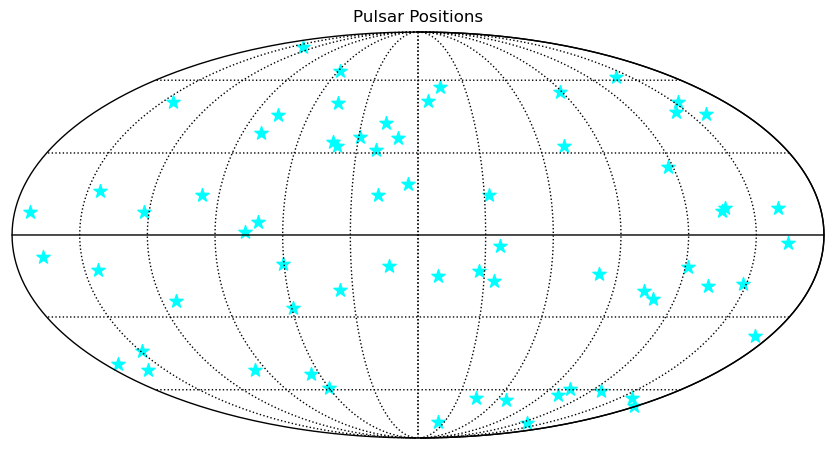

In [3]:
#Make figure here
hp.mollview(title = 'Pulsar Positions', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'cyan', marker = '*', s = 100)
plt.show()

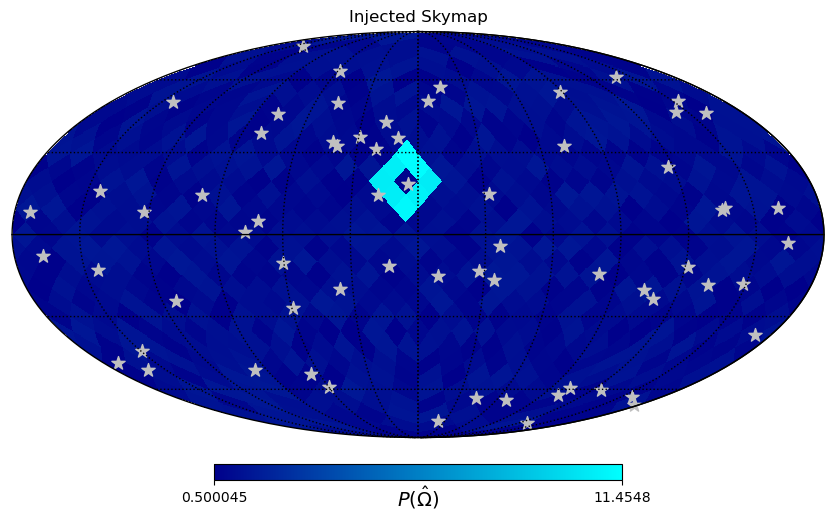

In [4]:
input_map = 0.5*np.ones(768)
input_map[192] += 10
input_map[224:226] += 10
input_map[[255,257]] += 10
input_map[288:290] += 10
input_map[320] += 10
input_map +=  np.random.rand(768)
#Make figure here
hp.mollview(input_map, title = 'Injected Skymap', unit = r'$P(\hat\Omega)$', rot=180, cmap=cmap)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

In [5]:
pta = apj.anis_pta(psrs_theta, psrs_phi, nside = 8, l_max = 8)

/home/tmoursy/miniforge3/envs/jaxmaps/lib/python3.12/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


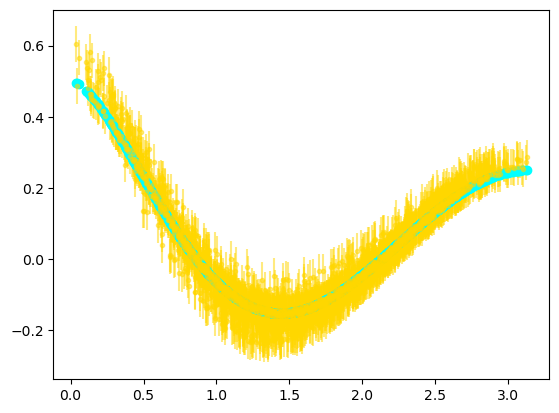

In [6]:
synth_rho = pta.F_mat @ input_map
synth_sig = np.repeat(0.1, repeats = 67*33)
# Plot the data
plt.errorbar(pta.xi, synth_rho, yerr = synth_sig / 2, ls = '', marker = '.', color='gold', alpha=.5)
plt.plot(pta.xi, pta.get_pure_HD(), marker = 'o', ls = '', color='cyan')
plt.show()

In [7]:
pta.set_data(synth_rho, synth_sig, 1)

Don't be too impressed if the next cell executes very quickly. The pixel basis takes ~30s in my experience to actually finish, but JAX uses asynchronous dispatching, so the cell might say it's done even when it's not. You'll have to wait the extra time when you run the cell after.

In [8]:
A2_sqrt, clm_sqrt, state_sqrt = pta.anisotropy_recovery(basis='sqrt', pair_cov=False)
A2_sph, clm_sph, state_sph = pta.anisotropy_recovery(basis='spherical', pair_cov=False)
pixel_map, pixel_state = pta.anisotropy_recovery(basis='pixel', pair_cov=False)
radio_map, radio_error = pta.anisotropy_recovery(basis='radiometer', pair_cov=False)

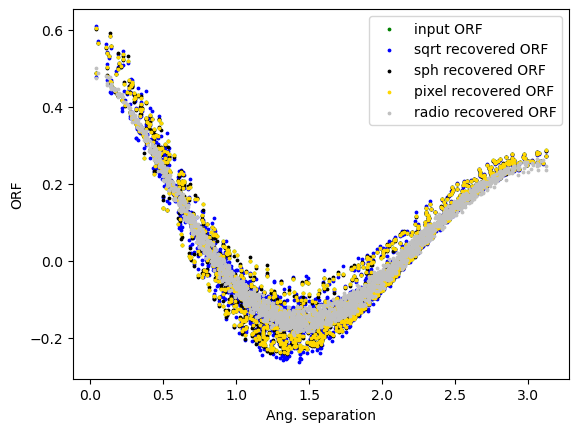

In [9]:
plt.scatter(pta.xi, synth_rho, color='green', label='input ORF',s=3)
plt.scatter(pta.xi, A2_sqrt*apj._clm2orf(clm_sqrt, pta.Gamma_lm), color='blue', label = 'sqrt recovered ORF',s=3)
plt.scatter(pta.xi, A2_sph*apj._clm2orf(clm_sph, pta.Gamma_lm), color='black', label = 'sph recovered ORF',s=3)
plt.scatter(pta.xi, apj._map2orf(pixel_map, pta.F_mat), color='gold', label = 'pixel recovered ORF',s=3)
plt.scatter(pta.xi, apj._map2orf(radio_map, pta.F_mat), color='silver', label = 'radio recovered ORF',s=3)

plt.xlabel(r"Ang. separation")
plt.ylabel(r"ORF")
plt.legend()
plt.show()

In [10]:
#Calculate the total, isotropic, and anisotropic S/N values

sn_sqrt = np.sqrt(pta.get_snrs_squared(np.array([A2_sqrt, *clm_sqrt]), 'sqrt', pair_cov=False))
sn_sph = np.sqrt(pta.get_snrs_squared(np.array([A2_sph, *clm_sph]), 'spherical', pair_cov=False))
sn_pixel = np.sqrt(pta.get_snrs_squared(pixel_map, 'pixel', pair_cov=False))
sn_radio = np.sqrt(pta.get_snrs_squared(radio_map, 'radiometer', pair_cov=False))

print('Square-root basis')
print('Total SNR:',sn_sqrt[0], 'Isotropic SNR:', sn_sqrt[1], 'Anisotropic SNR:', sn_sqrt[2])
print('Spherical harmonics basis')
print('Total SNR:',sn_sph[0], 'Isotropic SNR:', sn_sph[1], 'Anisotropic SNR:', sn_sph[2])
print('Pixel basis')
print('Total SNR:',sn_pixel[0], 'Isotropic SNR:', sn_pixel[1], 'Anisotropic SNR:', sn_pixel[2])
print('Radiometer basis')
print('Total SNR:',sn_radio[0], 'Isotropic SNR:', sn_radio[1], 'Anisotropic SNR:', sn_radio[2])

Square-root basis
Total SNR: 74.90168813161897 Isotropic SNR: 73.62233598517294 Anisotropic SNR: 13.784575766145979
Spherical harmonics basis
Total SNR: 75.16539053481345 Isotropic SNR: 73.62233598517314 Anisotropic SNR: 15.152147647686913
Pixel basis
Total SNR: 75.18378384568454 Isotropic SNR: 73.62233598517314 Anisotropic SNR: 15.24312951597859
Radiometer basis
Total SNR: 73.31371564155366 Isotropic SNR: 73.62233598517314 Anisotropic SNR: nan


/tmp/ipykernel_116529/1543753703.py:6: RuntimeWarning: invalid value encountered in sqrt
  sn_radio = np.sqrt(pta.get_snrs_squared(radio_map, 'radiometer', pair_cov=False))


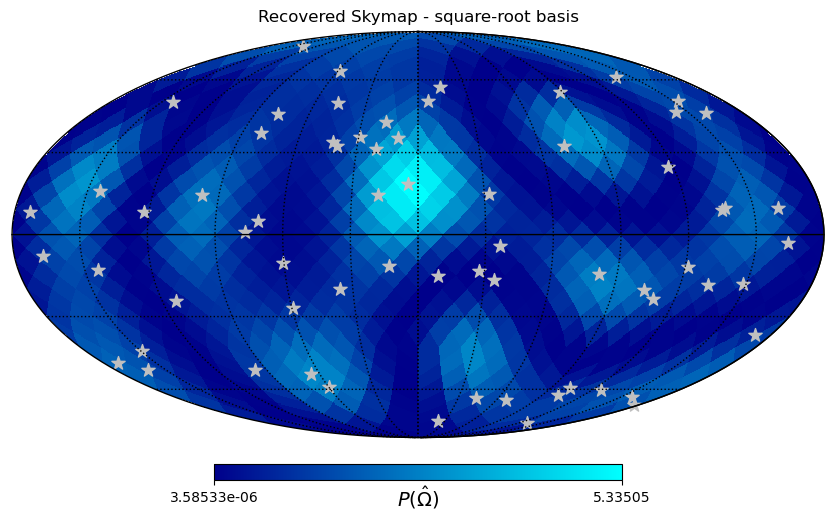

In [11]:
#Translate the c_lm to a sky map
recovered_map = A2_sqrt * ac.mapFromClm(clm_sqrt, nside = pta.nside) #Note we model the amplitude in log-space
#Make sky map
hp.mollview(recovered_map, title = 'Recovered Skymap - square-root basis', cmap=cmap, 
            unit=r'$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

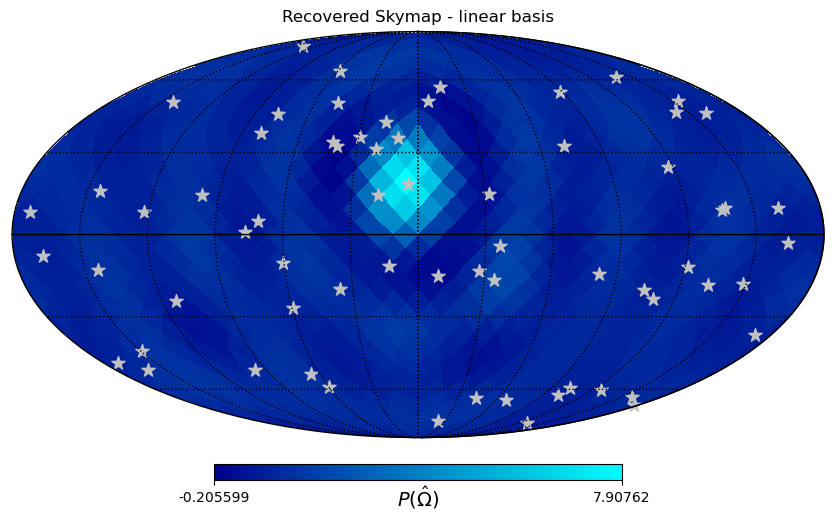

In [12]:
#Translate the c_lm to a sky map
recovered_map = A2_sph * ac.mapFromClm(clm_sph, nside = pta.nside) #Note we model the amplitude in log-space
#Make sky map
hp.mollview(recovered_map, title = 'Recovered Skymap - linear basis', cmap=cmap, 
            unit=r'$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

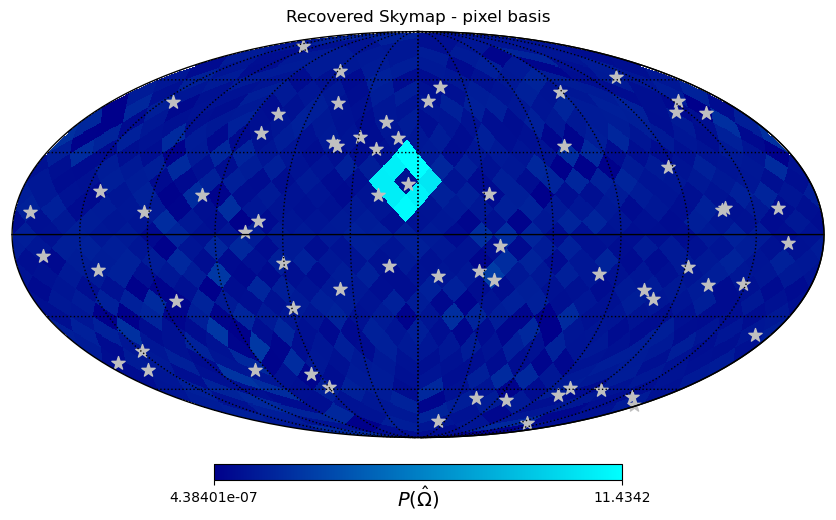

In [13]:
hp.mollview(pixel_map, title = 'Recovered Skymap - pixel basis', cmap=cmap, 
            unit=r'$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

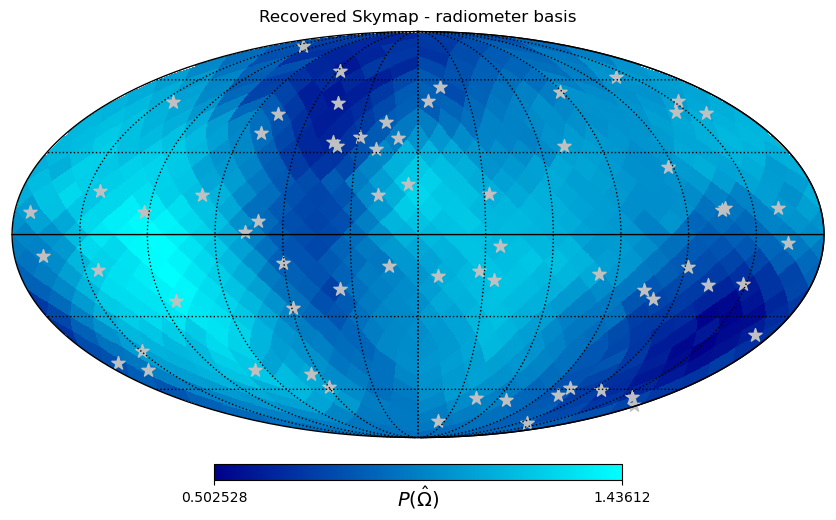

In [14]:
hp.mollview(radio_map, title = 'Recovered Skymap - radiometer basis', cmap=cmap, 
            unit=r'$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

We can also use jax.vmap to automatically vectorize over stacks of correlations or outputs from defiant.

For example, we can fit all frequencies of the PFOS and/or all noise draws of the NM(PF)OS.

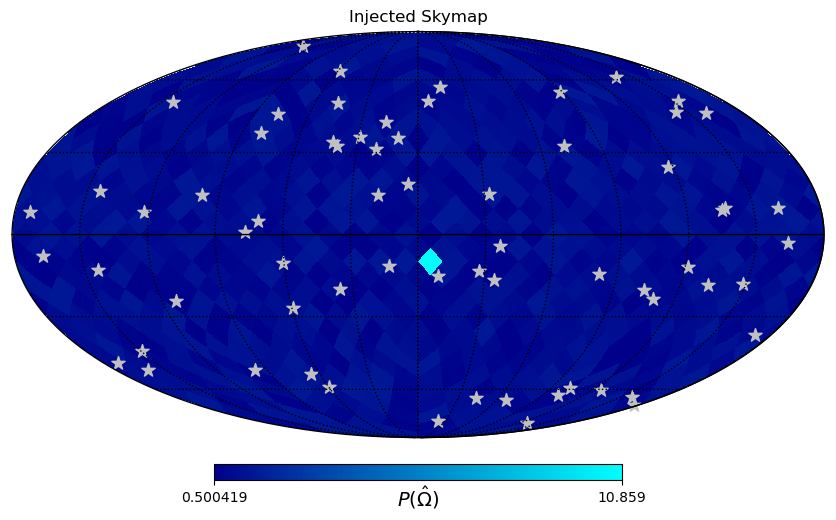

In [15]:
input_map1 = .5*np.ones(768)
input_map1[447] += 10
input_map1 += np.random.rand(768)
#Make figure here
hp.mollview(input_map1, title = 'Injected Skymap', unit = r'$P(\hat\Omega)$', rot=180, cmap=cmap)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

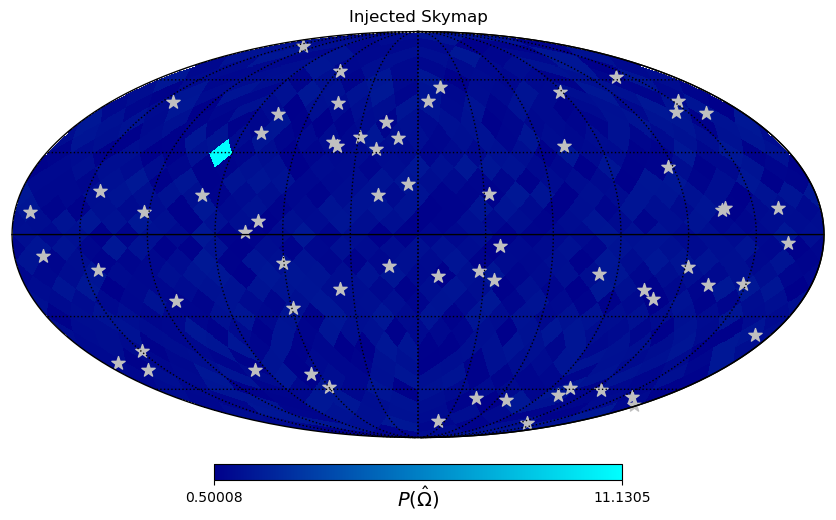

In [16]:
input_map2 = .5*np.ones(768)
input_map2[200] += 10
input_map2 += np.random.rand(768)
#Make figure here
hp.mollview(input_map2, title = 'Injected Skymap', unit = r'$P(\hat\Omega)$', rot=180, cmap=cmap)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

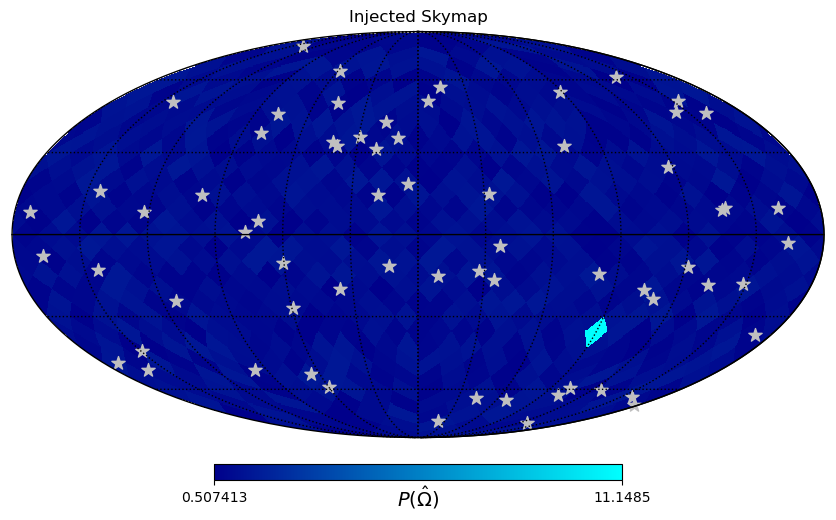

In [17]:
input_map3 = .5*np.ones(768)
input_map3[600] += 10
input_map3 += np.random.rand(768)
#Make figure here
hp.mollview(input_map3, title = 'Injected Skymap', unit = r'$P(\hat\Omega)$', rot=180, cmap=cmap)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

In [18]:
synth_rho1 = pta.F_mat @ input_map1
synth_rho2 = pta.F_mat @ input_map2
synth_rho3 = pta.F_mat @ input_map3

In [19]:
rhos = jnp.array([synth_rho1, synth_rho2, synth_rho3])
Lt = jnp.diag(1/synth_sig)
intial_guess_maps = 2*jnp.array(np.random.rand(3,pta.npix))
pixel_maps, states = jax.vmap(apj._pixel_basis, in_axes=[0,None,None,0])(rhos, pta.F_mat, Lt, intial_guess_maps)

In [20]:
pixel_maps.shape

(3, 768)

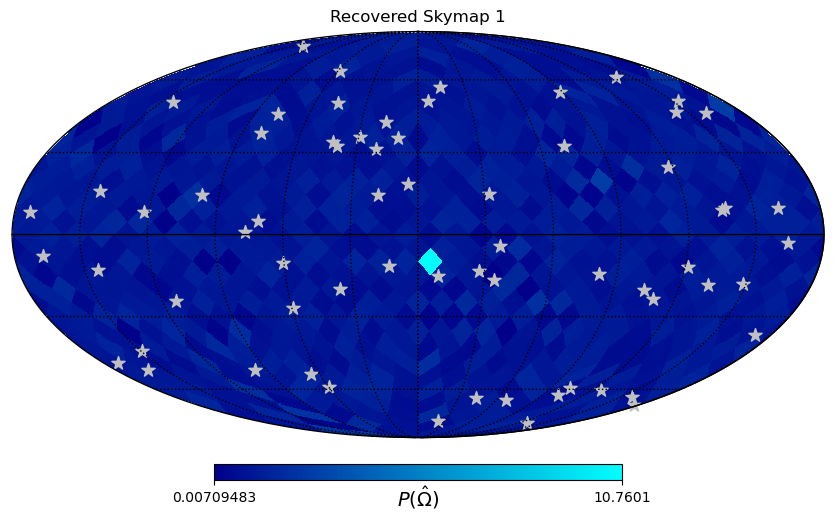

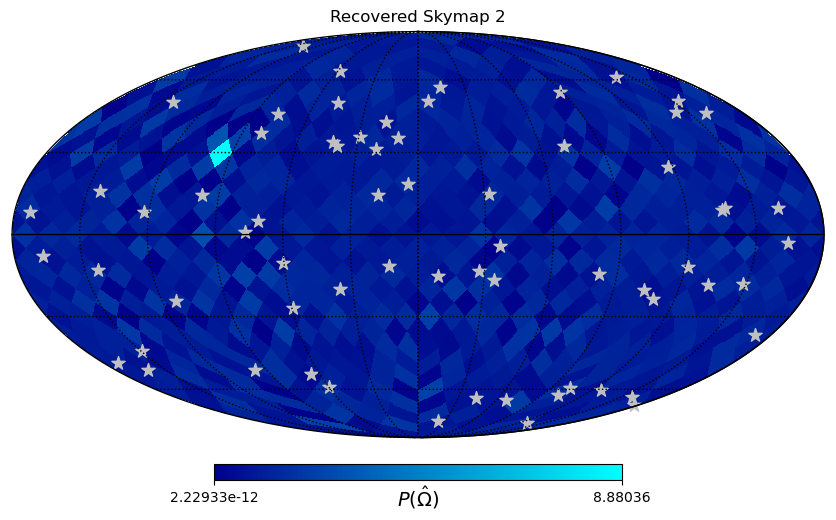

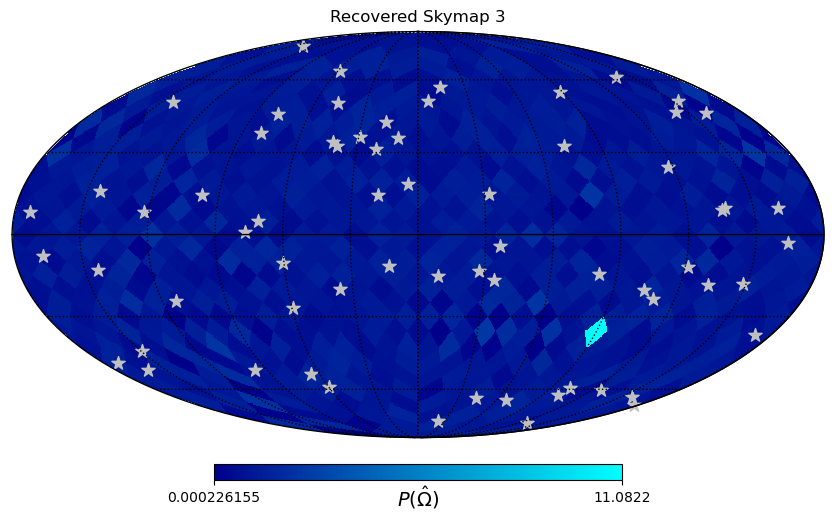

In [21]:
hp.mollview(pixel_maps[0], title = 'Recovered Skymap 1', cmap=cmap, 
            unit=r'$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

hp.mollview(pixel_maps[1], title = 'Recovered Skymap 2', cmap=cmap, 
            unit=r'$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

hp.mollview(pixel_maps[2], title = 'Recovered Skymap 3', cmap=cmap, 
            unit=r'$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(psrs_theta, psrs_phi, color = 'silver', marker = '*', s = 100)
plt.show()

You could also use jax.vmap( jax.vmap( ) ) for a 3d array of correlations and so on